In [125]:
import os
import glob
import numpy as np

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

Things to input first hand

number of nodes in each layer
activation function used


In [126]:
NOFNODES = 20

NOFATOMS = {'H': 128, 'O': 64} #as a dict

conv_energy = 5.5260279357571624
mean_energy = -5.7452783952905939


In [127]:
print(os.getcwd())
home = '/Users/shubhamdongriyal/my-drive/SabIA/HDNNP/H2O-Bing/MulRegression'

/Users/shubhamdongriyal/my-drive/SabIA/HDNNP/H2O-Bing/MulRegression/trainset/data-16


In [128]:
#dictionary of elements

id2el = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}
el2id = {v: k for k, v in id2el.items()}

In [177]:
# with open('/Users/shubhamdongriyal/my-drive/SabIA/HDNNP/H2O-Bing/MulRegression/trainset/data-1/function.cleaned.data') as f:
   
#     lines = f.readlines()
#     data = [line.split() for line in lines]


In [178]:
# el = np.asarray(sorted(list({x[0] for x in data})), dtype = int)

# print(f' Number of unique elements: {len(el)} \n 1st element: {el[0]} --- {id2el[el[0]]} \n 2nd element: {el[1]} --- {id2el[el[1]]}')

In [180]:
def symmetryfunction(FUNCTION, SCALING):
    # func_data = np.loadtxt(FUNCTION, usecols= range(0, NOOFSYM + 1)) # change 43 to dynamic number of columns
    # print(f' Shape of Symmetry functions: (number of atoms * number of frames) x (number of symmetry function + 1) \n {func_data.shape}')
    
    # el = list(set(func_data[:, 0])) # list of unique elements
    # print(f' Number of unique elements: {len(el)}')

    # print(f'1st element: {el[0]} --- {id2el[el[0]]}')
    # print(f'2nd element: {el[1]} --- {id2el[el[1]]}')

    # sf = {id2el[i]: func_data[np.any(func_data== i, axis = 1)][:, 1:43] for i in el}   #give symmetry function of each element

    with open(FUNCTION) as f:
        lines = f.readlines()
        data = [line.split() for line in lines] #data is in memory now

    el = np.asarray(sorted(list({x[0] for x in data})), dtype = int)

    print(f' Number of unique elements: {len(el)} \n 1st element: {el[0]} --- {id2el[el[0]]} \n 2nd element: {el[1]} --- {id2el[el[1]]}')

    l1, l2 = [], []
    for i in data:
        if i[0] == str(el[0]):
            l1.append(i)
        if i[0] == str(el[1]):
            l2.append(i)

    l1 = np.asarray(l1, dtype = float)
    l2 = np.asarray(l2, dtype = float)

    NOFSYM = [l1.shape[1] - 1, l2.shape[1] - 1]
    print(f'Number of symmetry functions:\n for el:1 {NOFSYM[0]} \n for el:2 {NOFSYM[1]}')

    sf = {id2el[el[0]]: l1[:, 1:NOFSYM[0] + 1], id2el[el[1]]: l2[:, 1:NOFSYM[1] + 1]}
    #code from here

    # Scaling of symmetry functions
    scale = np.loadtxt(SCALING, usecols= (2, 3, 4, 5))

    scalingmat = {id2el[el[0]]: scale[0:NOFSYM[0], :].T, id2el[el[1]]: scale[NOFSYM[0]:, :].T} #only for 2 elements have to generalize for more elements
    #print(scalingmat)

    #scaled symmetry functions
    scaledsf = {id2el[i]: ((sf[id2el[i]] - scalingmat[id2el[i]][2]) / (scalingmat[id2el[i]][1] - scalingmat[id2el[i]][0])) for i in el}

    return scaledsf, el, NOFSYM



In [181]:
def weightmat(wlist, el, NOFSYM):
    
    weights = {}
    for i, nofsym, wlist in zip(el, NOFSYM, wlist):
        w = np.loadtxt(wlist, usecols = 0)

        w0 = w[:nofsym * NOFNODES].reshape(nofsym, NOFNODES) #can be much more generalized
        b0 = w[nofsym * NOFNODES:(nofsym * NOFNODES) + NOFNODES]
        w1 = w[(nofsym * NOFNODES) + NOFNODES: (nofsym * NOFNODES) + NOFNODES + (NOFNODES * NOFNODES)].reshape(NOFNODES, NOFNODES)
        b1 = w[(nofsym * NOFNODES) + NOFNODES + (NOFNODES * NOFNODES) : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES)]
        w2 = w[(nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES]
        b2 = w[(nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES + 1]

        weights[id2el[i]] = [w0, b0, w1, b1, w2, b2]

    return weights

In [182]:
#activation functions

def activation(x, act):
    if act == 'sigmoid':
        return 1 / (1 + np.exp(-x))
    elif act == 'softplus':
        return np.log(1 + np.exp(x))
    elif act == 'ReLU':
        return np.maximum(0, x)
    elif act == 'tanh':
        return np.tanh(x)
    else:
        print('Invalid activation function')
        return None

# def sigmoid(x): return 1 / (1 + np.exp(-x))

# def softplus(x): return np.log(1 + np.exp(x))

# def ReLU(x): return np.maximum(0, x)

# def tanh(x): return np.tanh(x)

In [183]:
def forwardpass(scaledsf, weightmat, el):
    
    #same create dictionary for the elements
    featuresll = {}
    energycontri = {}
    
    for i in el:
        ll = []
        ec = []
        for j in range(scaledsf[id2el[i]].shape[0]):
            w0 = weightmat[id2el[i]][0]
            b0 = weightmat[id2el[i]][1]
            w1 = weightmat[id2el[i]][2]
            b1 = weightmat[id2el[i]][3]
            w2 = weightmat[id2el[i]][4]
            b2 = weightmat[id2el[i]][5]

            y1 = (w0.T @ scaledsf[id2el[i]][j]) + b0
            y1 = activation(y1, 'tanh')

            y2 = (w1.T @ y1) + b1
            y2 = activation(y2, 'tanh')

            ll.append(y2)
            y3 = (w2.T @ y2) + b2

            ec.append(y3)
        featuresll[id2el[i]] = np.array(ll).reshape(-1, NOFATOMS[id2el[i]], NOFNODES)   # reshaping over here to make it compatible with the energy contribution
        energycontri[id2el[i]] = np.array(ec).reshape(-1,NOFATOMS[id2el[i]], 1)

    return featuresll, energycontri

In [184]:
def feature_extractor(FUNCTION, SCALING):
    scaledsf, el, NOFSYM = symmetryfunction(FUNCTION, SCALING)
    weights = weightmat(wlist = sorted(glob.glob(os.path.join(home, 'weight*'))), el = el, NOFSYM = NOFSYM)
    featuresll, energycontri = forwardpass(scaledsf = scaledsf, weightmat = weights, el = el)

    return featuresll, energycontri

I have to use train function multiple time to create a dictionary of models on which i can perform Linear Regressions.

model1 = [features , energy contri]
model2 = [...]
:
:   

In [185]:
datasets = sorted(glob.glob(os.path.join(home, 'trainset/data-*')), key= lambda x: int(x.split('-')[-1]))

def committee():
    committee_model = {}
    for model, dataset in enumerate(datasets):
        os.chdir(dataset)
        (features, energy_contribution) = feature_extractor(FUNCTION = 'function.cleaned.data', SCALING = 'scaling.data')

        committee_model['model-' + str(model)] = (features, energy_contribution)
    
    return committee_model
    

In [186]:
committee_model = committee()

 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8

In [205]:
committee_model['model-10'][1]['H']

array([[[-2.94730105e-01],
        [-2.27819557e-01],
        [-3.09868355e-01],
        ...,
        [-3.65736481e-01],
        [-1.74791512e-01],
        [-2.68803625e-01]],

       [[-4.94158493e-01],
        [-4.42364783e-01],
        [-3.02769470e-01],
        ...,
        [-7.01996004e-01],
        [-3.22274734e-01],
        [-3.81595244e-01]],

       [[-6.10510830e-01],
        [-3.08928238e-01],
        [-2.46676339e-01],
        ...,
        [-3.50309389e-01],
        [-4.25181616e-01],
        [-3.40420634e-04]],

       ...,

       [[-5.61304216e-01],
        [-4.55470162e-01],
        [-3.24266735e-01],
        ...,
        [-4.07489003e-01],
        [-6.35474317e-01],
        [-5.33376203e-01]],

       [[-6.46931320e-01],
        [-6.46969055e-01],
        [-3.92688970e-01],
        ...,
        [-4.42337527e-01],
        [-4.86759134e-01],
        [-6.36829631e-01]],

       [[-2.11781069e-01],
        [-4.60268088e-01],
        [-6.45182218e-01],
        ...,
        

In [151]:
# committee_model['model-0'][0]['C'].reshape(-1, 80, 25).shape # [0] for features, [1] for energy contribution


In [231]:
# #plotting the feature vs atomic contribution for H1 for different models

# # fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
# # plt.subplots_adjust(hspace=0.5)

# plt.figure( figsize= (15, 12))
# plt.subplots_adjust(hspace=0.5)
# for key, values in committee_model.items():
#     x = values[0]['H']
#     y = values[1]['H']

#     ax = plt.subplot(4, 4, int(key.split('-')[-1]) + 1)
#     ax.scatter(x[:, 0, :], y[:, 0, 0])


In [395]:
#These should be from the full training function.data values


def linear_regression(committee_model, el):
    lr_models = {}
    for key, values in enumerate(committee_model.values()):
        lr ={}
        for j in el:
            x = values[0][id2el[j]]
            y = values[1][id2el[j]]

            print(x.shape, y.shape)

            lr[id2el[j]] = [LinearRegression(fit_intercept= False).fit(x[:, k, :], y[:, k, 0]) for k in range(NOFATOMS[id2el[j]])] #dic for LR for 1 model
        
        lr_models['model-' + str(key)] = lr
        
    return lr_models
#un-scaling should be done only at prediction


In [396]:
lr_models = linear_regression(committee_model, el = el)

(835, 128, 20) (835, 128, 1)
(835, 64, 20) (835, 64, 1)
(759, 128, 20) (759, 128, 1)
(759, 64, 20) (759, 64, 1)
(806, 128, 20) (806, 128, 1)
(806, 64, 20) (806, 64, 1)
(817, 128, 20) (817, 128, 1)
(817, 64, 20) (817, 64, 1)
(793, 128, 20) (793, 128, 1)
(793, 64, 20) (793, 64, 1)
(804, 128, 20) (804, 128, 1)
(804, 64, 20) (804, 64, 1)
(797, 128, 20) (797, 128, 1)
(797, 64, 20) (797, 64, 1)
(823, 128, 20) (823, 128, 1)
(823, 64, 20) (823, 64, 1)
(811, 128, 20) (811, 128, 1)
(811, 64, 20) (811, 64, 1)
(811, 128, 20) (811, 128, 1)
(811, 64, 20) (811, 64, 1)
(800, 128, 20) (800, 128, 1)
(800, 64, 20) (800, 64, 1)
(801, 128, 20) (801, 128, 1)
(801, 64, 20) (801, 64, 1)
(798, 128, 20) (798, 128, 1)
(798, 64, 20) (798, 64, 1)
(773, 128, 20) (773, 128, 1)
(773, 64, 20) (773, 64, 1)
(822, 128, 20) (822, 128, 1)
(822, 64, 20) (822, 64, 1)
(793, 128, 20) (793, 128, 1)
(793, 64, 20) (793, 64, 1)


Weights are same for all the models in linear regression model.

But if the turn off the intercept then values are differing.

In [397]:
print(lr_models['model-0']['H'][100].intercept_)

0.0


In [398]:
#test set selection and prediction
feature_test, energy_test = feature_extractor(FUNCTION = os.path.join(home, 'testset/test-orig/function.cleaned.data'), SCALING = os.path.join(home, 'testset/test-orig/scaling.data'))
NOFFRAMES_TEST = feature_test['O'].shape[0]

 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30


In [393]:
#prediction for single frame
def prediction(lr_models, feature_test, energy_test, el):

    atomic_contri = {}
    total_energy = {}
    for key, values in enumerate(lr_models.values()):
        lr_pred = {}
        el_en = []
        for j in el:
            x = feature_test[id2el[j]]
            y = energy_test[id2el[j]].reshape(NOFATOMS[id2el[j]],1)
            
            lr_pred[id2el[j]] = [ (y[k] / conv_energy, values[id2el[j]][k].predict(x[:, k, :]) / conv_energy) for k in range(NOFATOMS[id2el[j]])] #dic of list of tuples containing UNSCALED (true_y, y_pred) 
            
            el_en.append(np.sum([en[1] + mean_energy for en in lr_pred[id2el[j]]]))

        atomic_contri['model-' + str(key)] = lr_pred
        total_energy['model-' + str(key)] = np.sum(el_en)

    return atomic_contri, total_energy


In [394]:
#single prediction
atomic_contri, total_energy = prediction(lr_models, feature_test, energy_test, el)  #correct

committee_mean = np.mean(list(total_energy.values()))
committee_std = np.std(list(total_energy.values()))

print(f'Total Number of Committee NNs: {len(total_energy)}')
print(f'Committee Mean Energy: {committee_mean} eV\nCommittee Standard Deviation: {committee_std} eV')

ValueError: cannot reshape array of size 20608 into shape (128,1)

In [399]:
#prediction for multiple frames
def multi_frame_prediction(lr_models, feature_test, energy_test, el):
    total_energy = {}
    for key, values in enumerate(lr_models.values()):  #model loop
        energies = []
        for k in range(NOFFRAMES_TEST): #frame loop
            frame_energy = []
            for j in el:    #element loop
                #frame_energy_el = 0
                x = feature_test[id2el[j]][k]
                #y = energy_test[id2el[j]][k].reshape(NOFATOMS[id2el[j]],1) #no need for prediction anyway

                kframe_encontri_el = [(values[id2el[j]][z].predict(x[z, :].reshape(1, -1)) / conv_energy) for z in range(NOFATOMS[id2el[j]])] #atom loop
                frame_energy_el = np.sum([encon + mean_energy for encon in kframe_encontri_el])

                frame_energy.append(frame_energy_el)
            #print(len(frame_energy))
            total_frame_one_energy = np.sum(frame_energy)
            energies.append(total_frame_one_energy)

        total_energy['model-' + str(key)] = energies
    return total_energy

                    

In [400]:
#multiple prediction at once
total_energy = multi_frame_prediction(lr_models, feature_test, energy_test, el = el)
en_mat =  np.asarray([i for i in total_energy.values()])
mean_energy_per_frame = np.mean(en_mat, axis = 0)
std_energy_per_frame = np.std(en_mat, axis = 0)

In [388]:
std_energy_per_frame

array([2.27373675e-13, 2.47774718e-13, 2.66619268e-13, 4.54747351e-13,
       1.13686838e-13, 3.97903932e-13, 2.27373675e-13, 2.27373675e-13,
       2.27373675e-13, 0.00000000e+00, 2.20153615e-13, 4.54747351e-13,
       0.00000000e+00, 4.54747351e-13, 2.27373675e-13, 2.27373675e-13,
       2.27373675e-13, 2.27373675e-13, 4.54747351e-13, 2.47774718e-13,
       0.00000000e+00, 0.00000000e+00, 2.27373675e-13, 8.03887339e-14,
       4.54747351e-13, 2.27373675e-13, 1.13686838e-13, 2.27373675e-13,
       2.66619268e-13, 2.27373675e-13, 0.00000000e+00, 4.54747351e-13,
       1.96911379e-13, 2.27373675e-13, 0.00000000e+00, 2.27373675e-13,
       1.39237371e-13, 2.27373675e-13, 0.00000000e+00, 4.54747351e-13,
       1.70530257e-13, 2.27373675e-13, 8.03887339e-14, 2.27373675e-13,
       4.54747351e-13, 0.00000000e+00, 0.00000000e+00, 2.27373675e-13,
       0.00000000e+00, 5.68434189e-14, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.03887339e-14, 0.00000000e+00, 0.00000000e+00,
      

ANALYSIS

In [401]:
#true energy
true_energy = np.loadtxt(os.path.join(home, 'testset/test-orig/energy.data'))

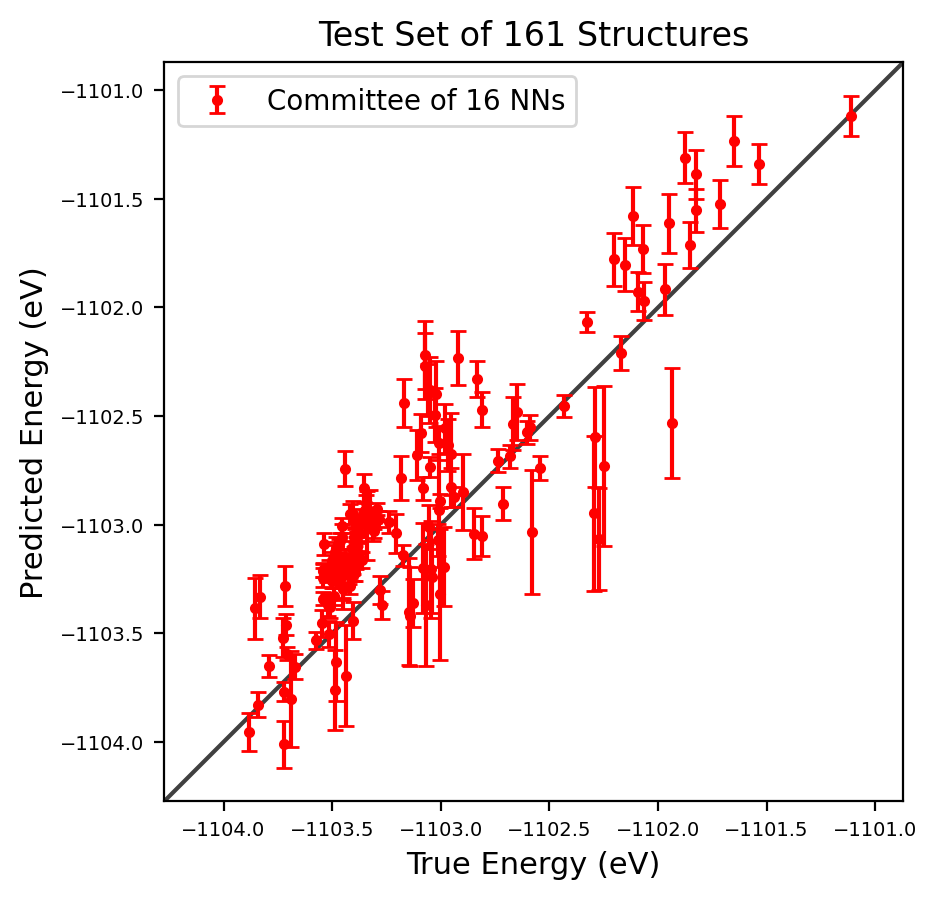

In [461]:
#Plotting Energy True vs Energy Predicted

# plt.figure(dpi = 200)
# plt.plot([-1104, -1100], [-1104, -1100])
fig, ax = plt.subplots(dpi = 200)
ax.errorbar(true_energy, mean_energy_per_frame, yerr = std_energy_per_frame, fmt= 'o', markersize = 3, capsize = 3, color = 'r', label = 'Committee of 16 NNs')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.xlabel('True Energy (eV)', fontsize = 11)
plt.ylabel('Predicted Energy (eV)', fontsize = 11)
plt.title('Test Set of 161 Structures', fontsize = 12)
plt.legend()
#plt.savefig(os.path.join(home,'MLR/E-true_vs_E-comm_16.pdf'), dpi=200, format='pdf', bbox_inches= 'tight', pad_inches=0.1,)
plt.show()